### Develop an ML Linear Regression model to learn High Entropy Alloy Hardness Property

In this tutorial we will learn to create an ML model for harness property prediction for high entropy alloys. We will go through the following steps:

1. Load training dataset and separate X and y columns
2. Visualize the alloy property and feature data
3. Use scikit-learn library to build alloy hardness prediction model (linear regression)
4. Model assessment, cross-validation

### Importand python library imports

In [122]:
import pandas as pd  # To play with data tables
import matplotlib.pyplot as plt  # To visualize data
import numpy as np # for numerical operations
import copy

In [123]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge

In [124]:
from sklearn.model_selection import KFold

### 1. Load train data table

In [125]:
!gdown 1i5c01hhj04J816siI-6u3ea32vI-HToy

Downloading...
From: https://drive.google.com/uc?id=1i5c01hhj04J816siI-6u3ea32vI-HToy
To: /content/alloy-confp-train-data.csv
100% 7.22k/7.22k [00:00<00:00, 24.6MB/s]


In [126]:
data = pd.read_csv('/content/alloy-confp-train-data.csv')

data

,ID,HV,C.al,C.co,C.cr,C.cu,C.fe,C.ni
0,25,170,0.056604,0.000000,0.188679,0.188679,0.188679,0.377358
1,60,380,0.200000,0.266667,0.000000,0.000000,0.266667,0.266667
2,155,775,0.400000,0.200000,0.200000,0.000000,0.200000,0.000000
3,88,486,0.208333,0.000000,0.208333,0.208333,0.208333,0.166667
4,2,118,0.024390,0.243902,0.243902,0.000000,0.243902,0.243902
...,...,...,...,...,...,...,...,...
115,59,371,0.166667,0.000000,0.555556,0.000000,0.000000,0.277778
116,104,537,0.166667,0.166667,0.166667,0.083333,0.250000,0.166667
117,116,558,0.264706,0.147059,0.147059,0.147059,0.147059,0.147059
118,154,768,0.400000,0.133333,0.066667,0.133333,0.200000,0.066667


#### Notes about the data table

Above we see that data table has 3 types of columns:
1. ID: Serial number of the alloys.
2. HV: This is the experimentally measured hardness values of the alloys. Our target property (y).    
3. C.*: concentration of different elements in the alloys.

In [127]:
data = data.sample(frac=1) # shuffle the rows of the dataset

In [128]:
data.to_csv('/content/alloy-confp-train-data_v2.csv')

#### Separate X and y data

In [129]:
Xcols = data.columns[data.columns.str.contains("C.")]
X = data[Xcols]
X

,C.al,C.co,C.cr,C.cu,C.fe,C.ni
23,0.212575,0.212575,0.212575,0.000000,0.149701,0.212575
44,0.148936,0.212766,0.212766,0.000000,0.212766,0.212766
45,0.250000,0.250000,0.000000,0.000000,0.250000,0.250000
36,0.333333,0.000000,0.133333,0.133333,0.133333,0.266667
107,0.149925,0.283358,0.283358,0.000000,0.283358,0.000000
...,...,...,...,...,...,...
92,0.000000,0.225000,0.225000,0.225000,0.100000,0.225000
61,0.250000,0.250000,0.250000,0.000000,0.000000,0.250000
93,0.000000,0.212575,0.212575,0.212575,0.149701,0.212575
43,0.230769,0.192308,0.192308,0.000000,0.192308,0.192308


In [130]:
y = data['HV']
y

23     558
44     338
45     430
36     593
107    655
      ... 
92     172
61     712
93     171
43     479
90     694
Name: HV, Length: 120, dtype: int64

### 2. Visualize data

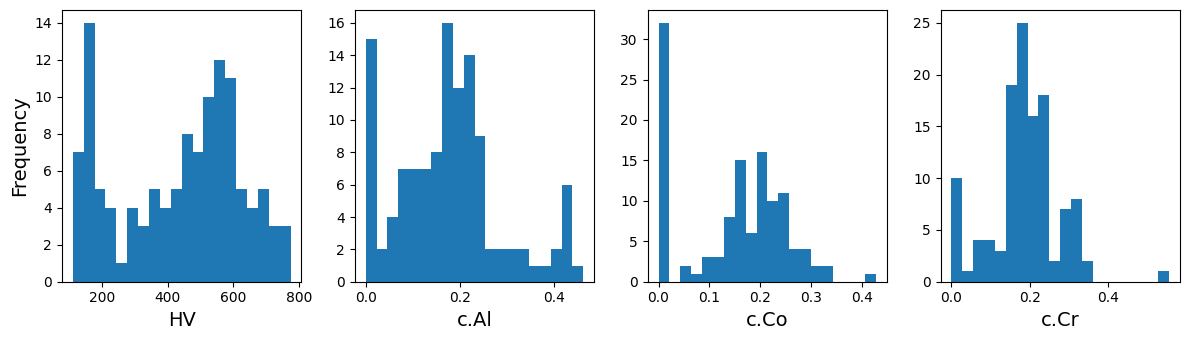

In [131]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(12,3.5)) # fig of 4 subplots

ax1.hist(y.values, bins=20)
ax2.hist(X.values[:,0], bins=20, label='c.Al')
ax3.hist(X.values[:,1], bins=20, label='c.Co')
ax4.hist(X.values[:,2], bins=20, label='c.Cr')

ax1.set_xlabel('HV', fontsize=14)
ax2.set_xlabel('c.Al', fontsize=14)
ax3.set_xlabel('c.Co', fontsize=14)
ax4.set_xlabel('c.Cr', fontsize=14)

ax1.set_ylabel('Frequency', fontsize=14)

plt.tight_layout()

### Question


1. What is the use of visualizing target property and features data? Give examples of a few scenarios where data visualization could be helpful.

* <B>Understanding the Data Distribution</B> : By doing this we are able to identify the outliers, skewness and check if there are any patterns in the data.

* <B>Identify the relationship</B>: By looking at the plot we can assume a relationship between the target value and the feature.

* <B>Example</B> <I> Healthcare </I>: By visualisin patients demographics and medical results can help prefessional identify risk factor for certain medical conditions.

* <B> Exxample </B> <I> Stock market analysis </I>: By visualising the distribution of financial indicators and stock prices we help analysis identify patterns helping in making decisions.


### 3. Train an ML model

In [132]:
# First we will define function to make plots. This will make the code simpler.

def polt_parity(y_cv_test,y_pred_test, y_cv_train=None,y_pred_train=None, label=None, ylim=[50,900]):
    """
    Function to make parity plots.

    y_cv_test: True values of the target variable for the test set.
    y_pred_test: Predicted values of the target variable for the test set.

    """

    # Plot Parity plot
    rmse_test = np.sqrt(mean_squared_error(y_cv_test,y_pred_test))
    r2_test = r2_score(y_cv_test,y_pred_test)

    if y_cv_train is None:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4), sharey=True, sharex=True)
    else:
        fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,4), sharey=True, sharex=True)

    ax1.scatter(y_cv_test,y_pred_test)
    ax1.text(0.95, 0.26, label, transform=ax1.transAxes, ha='right', fontsize=14)
    ax1.text(0.95, 0.18, "RMSE: %.2f"%rmse_test, transform=ax1.transAxes, ha='right', fontsize=14)
    ax1.text(0.95, 0.1, "R$^2$: %.2f"%r2_test, transform=ax1.transAxes, ha='right', fontsize=14)
    ax1.plot(ylim, ylim, '--k')
    ax1.set_xlabel('True y', fontsize=14)
    ax1.set_ylabel('Pred y', fontsize=14)
    ax1.set_xlim(ylim[0],ylim[1])
    ax1.set_ylim(ylim[0],ylim[1])

    if y_cv_train is not None:
        rmse_train = np.sqrt(mean_squared_error(y_cv_train,y_pred_train))
        r2_train = r2_score(y_cv_train,y_pred_train)

        ax2.scatter(y_cv_train,y_pred_train, c='m')
        ax2.text(0.95, 0.26, "Train", transform=ax2.transAxes, ha='right', fontsize=14)
        ax2.text(0.95, 0.18, "RMSE: %.2f"%rmse_train, transform=ax2.transAxes, ha='right', fontsize=14)
        ax2.text(0.95, 0.1, "R2: %.2f"%r2_train, transform=ax2.transAxes, ha='right', fontsize=14)
        ax2.plot(ylim, ylim, '--k')

        ax2.set_xlabel('True y', fontsize=14)
        ax2.set_xlim(ylim[0],ylim[1])
        ax2.set_ylim(ylim[0],ylim[1])

    plt.tight_layout()
    plt.show()

    return None

#### Our own LR code using the equation discuseed in class

In [133]:
X_tras_X_inv = np.linalg.inv(np.dot(X.T,X)) # compute inverse of (X tanspose) X
X_tras_y = np.dot(X.T,y) # Compute (X transpose).y
w_cap_vec = np.dot(X_tras_X_inv,X_tras_y) # compute coefficients of w_cap
y_pred_manual = np.dot(X,w_cap_vec) # compute predictions y_cap

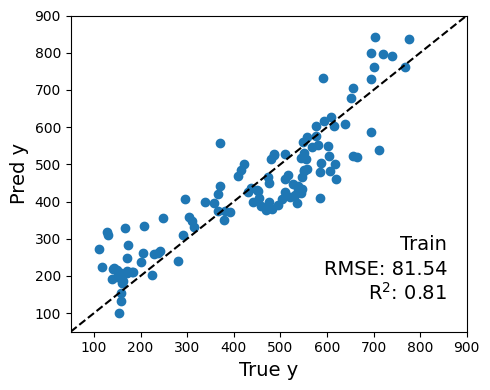

In [134]:
polt_parity(y,y_pred_manual, label="Train") # to visualise manually predictions align with true target value

#### Using sklearn in-built python library

In [135]:
lr = LinearRegression(fit_intercept=False) # create a instance of the class
model = lr.fit(X,y) # fit the data
lr_model = copy.deepcopy(model) # create a deep copy to make changes in lr_model and not affect original model object

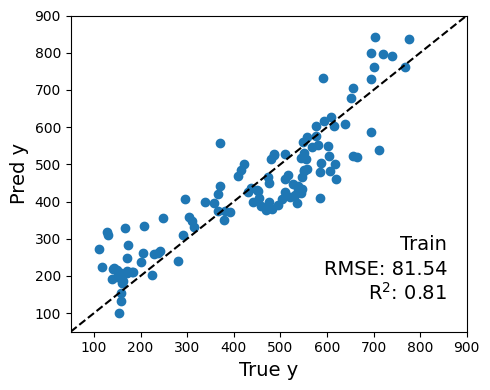

In [136]:
y_pred = model.predict(X) # predict from lr model
polt_parity(y,y_pred, label="Train")

#### Comparing sklearn library vs our equation results

In [137]:
print("Sklearn model: ", lr_model.coef_)
print("Eq. based model: ", w_cap_vec)

Sklearn model:  [1589.03703891  154.02145017  647.00169133  279.68594241  204.32826373
 -241.42532589]
Eq. based model:  [1589.03703891  154.02145017  647.00169133  279.68594241  204.32826373
 -241.42532589]


#### Error with baseline average model

In [138]:
y_avg_pred = [y.mean()]*len(y)
print("Root mean squared error: %.2f" % np.sqrt(mean_squared_error(y, y_avg_pred)))

# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y, y_avg_pred))

Root mean squared error: 186.35
Coefficient of determination: 0.00


### Question


2. Why is it important to compare model performance with a baseline model?

* By comparing the moel performances with the baselin model provides insights into the effectiveness and the correct suitablity of the model which are predicting the the hardness property in this case.

* It is useful to validate the model performance, to interpret results, and improve the model by repetition (iterative approach)

3. Is there any issue with the way we have computed the accuracy/ performance of the linear regression model?

* the issue while calculating the performance is that we are using the average of target values as the prediction of the baseline model.

* With this simple baseline, it may not capture the patterns in the data accurately.

* We cannot be only dependent on the baseline model to calculate the performance.

### 4. Model assessment, cross-validation

Cross validation is mainly used to prevent overfitting

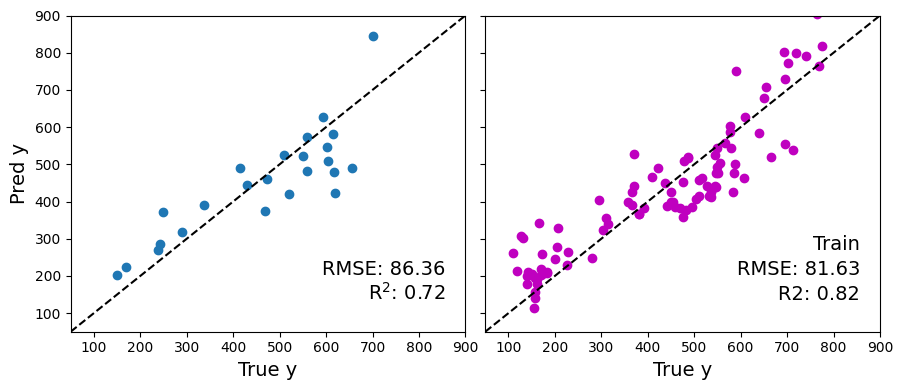

Root mean squared error: 86.36
Coefficient of determination: 0.72


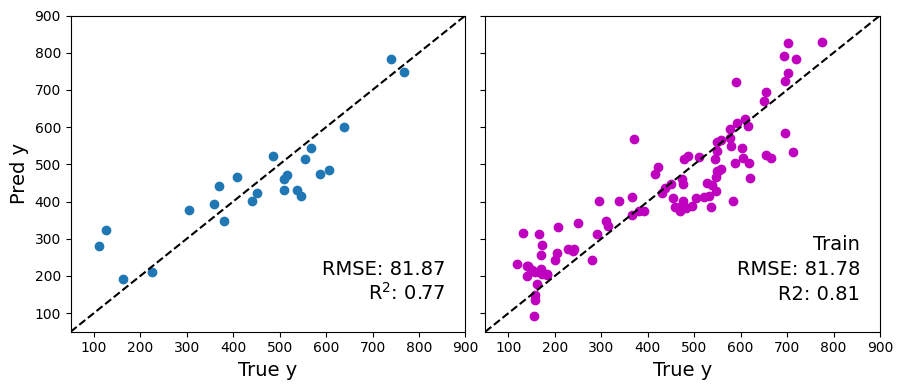

Root mean squared error: 81.87
Coefficient of determination: 0.77


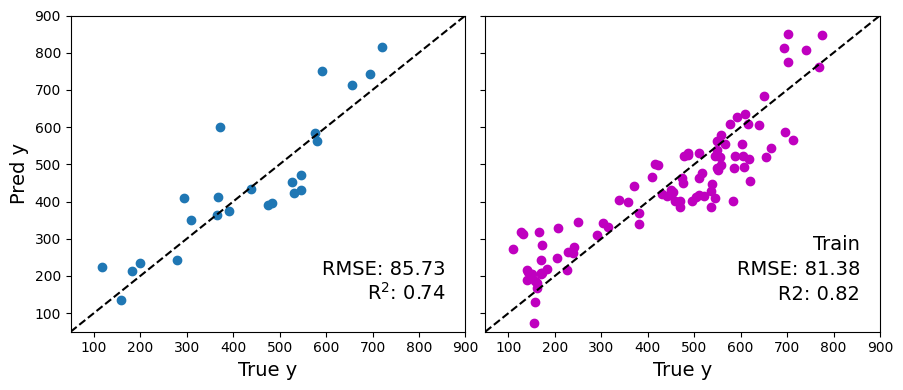

Root mean squared error: 85.73
Coefficient of determination: 0.74


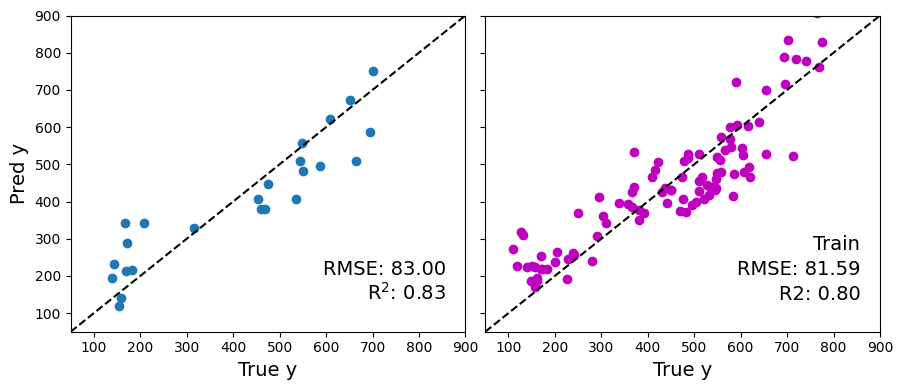

Root mean squared error: 83.00
Coefficient of determination: 0.83


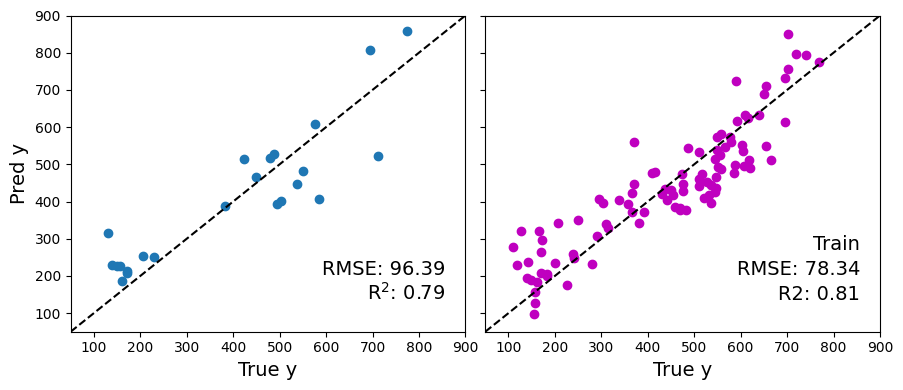

Root mean squared error: 96.39
Coefficient of determination: 0.79


In [139]:
kf = KFold(n_splits=5) # 5 folds

errors = [] # store the errors for each case

for idx, (train, test) in enumerate(kf.split(X)): # iterate over each fold
    X_cv_train = X.values[train] # split the data
    X_cv_test = X.values[test]

    y_cv_train = y.values[train]
    y_cv_test = y.values[test]


    # Model fit and prediction
    model = lr.fit(X_cv_train,y_cv_train)
    y_pred_test = model.predict(X_cv_test)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_test = np.sqrt(mean_squared_error(y_cv_test, y_pred_test))
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_test = r2_score(y_cv_test, y_pred_test)
    r2_train = r2_score(y_cv_train, y_pred_train)


    # Plot Parity plot
    polt_parity(y_cv_test,y_pred_test, y_cv_train,y_pred_train)

    print("Root mean squared error: %.2f" % rmse_test)
    print("Coefficient of determination: %.2f" % r2_test)

    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'r2_train': r2_train,
             'rmse_test': rmse_test,
             'r2_test': r2_test
            }

    errors.append(error)

In [140]:
errors = pd.DataFrame(errors)
errors

,kfold,rmse_train,r2_train,rmse_test,r2_test
0,1,81.629866,0.817608,86.364375,0.716488
1,2,81.778613,0.813427,81.871122,0.774769
2,3,81.384873,0.817652,85.727160,0.740569
3,4,81.593592,0.797047,82.998707,0.833648
4,5,78.338244,0.807965,96.391397,0.794651


### Question


4. Why error on training set is consistently lower than that on validation set?


According to my understanding there might be few reasons

* <B> Overfitting </B>: It captures the noise and the random fluctuations present in the training set instead of generalising the new data.
* <B> Cross Validation Variability </B>: In k fold there are partition in the train, validation split so there is variability in the error metrics between training and validation error for each set of fold.

5. Further, the errors on various validation sets are also different. Which is the correct value that best estimate the performance of the ML model?

* The average or median value of the error metrics across all validation data.
* To compare the errors of training nad validation sets.If the training error is significantly lower than the validation error the model is probably overfitting.

In [141]:
errors[['rmse_test','r2_test']].mean()

rmse_test    86.670552
r2_test       0.772025
dtype: float64

### Question


6. Is MSE on training data expected to be higher or lower than that on validation/test errors? Discuss.


* So basically in training data it learns the underlying trends, patterns and relationships and then tries to predict so it is expected to have a lower MSE

* For testing the model on validation data the MSE is higher than the training data as the it does not accurately predict the results.

* If there is a significant difference between the MSE values for the training and the validation data it tell us that the model is overfitted.

* If the difference is low then we can say thatthe model has learned to generalise and capture the underlying patterns in the data without overfitting.


7. For various values of k-folds, ranging from 2-10, plot average validation RMSE error. Discuss the behavior of the obtained plot.


In [142]:
avg_rmse_kfold = []

for k_fold in range(2, 11):
    kf = KFold(n_splits=k_fold)

    fold_errors = []

    for fold_idx, (train, test) in enumerate(kf.split(X)):
        X_train = X.values[train]
        X_test = X.values[test]

        y_train = y.values[train]
        y_test = y.values[test]

        model = lr.fit(X_train, y_train)
        y_pred_test = model.predict(X_test)
        y_pred_train = model.predict(X_train)

        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

        r2_test = r2_score(y_test, y_pred_test)
        r2_train = r2_score(y_train, y_pred_train)

        fold_error = {
            'fold': fold_idx + 1,
            'rmse_train': rmse_train,
            'r2_train': r2_train,
            'rmse_test': rmse_test,
            'r2_test': r2_test
        }

        fold_errors.append(fold_error)
    err = pd.DataFrame(fold_errors)
    avg_rmse_kfold.append(err['rmse_test'].mean())

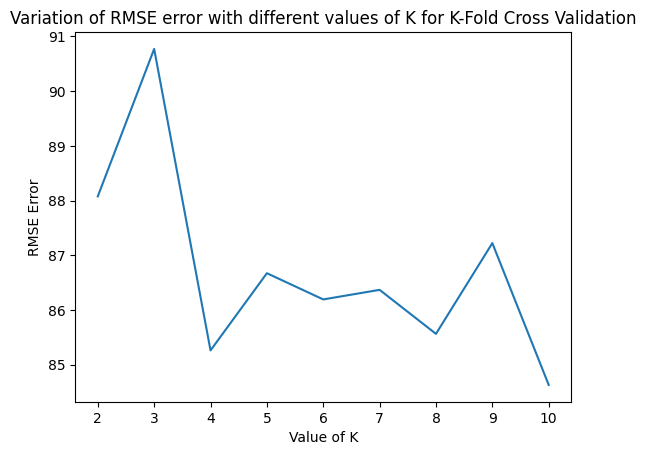

In [143]:
import matplotlib.pyplot as plt
Kfolds = [2,3,4,5,6,7,8,9,10]
plt.plot(Kfolds, avg_rmse_kfold)
plt.xlabel("Value of K")
plt.ylabel("RMSE Error")
plt.title("Variation of RMSE error with different values of K for K-Fold Cross Validation")

plt.show()


* as we increase the folds the trend decreases as we are we are basically reducing the number of training data.
* After a specific value of k-fold there would be a minimised average validation RMSE.
* More number of K leads ti larger computational costs.

8. Instead of solving the linear regression problem using analytical methods (discussed in class), we could have used numerical methods, such as, gradient descent - for instance see this blog post https://towardsdatascience.com/linear-regression-using-gradient-descent-97a6c8700931. Write a code that uses numerical method to fit a linear regression model to this alloy dataset. Compare the coefficients obtained using the analytical and the numerical methods. Discuss scenarios wherein one method may have advantage over the other.

In [150]:
def gradient_descent(X, y, m, c, alpha, epochs):
    n = len(y)

    for i in range(epochs):
        predictions = np.dot(X, m) + c  # Perform dot product correctly
        errors = np.subtract(y, predictions)
        sum_delta_m = (-2 / n) * np.dot(X.T, errors)
        m = m - alpha * sum_delta_m

    return m, c

In [151]:
average_m = [0,0,0,0,0,0]
avg_rmse_kfold = []

kf = KFold(n_splits=5)

fold_errors = []

for fold_idx, (train, test) in enumerate(kf.split(X)):
    X_train = X.values[train]
    X_test = X.values[test]

    y_train = y.values[train]
    y_test = y.values[test]

    m = np.zeros(X_train.shape[1])
    c = 0
    learning_rate = 0.006
    epochs = 50000

    m, c = gradient_descent(X_train, y_train, m, c, learning_rate, epochs)


    num_m = []

    for i in range(len(m)):
        num_m.append(m[i]);

    for i in range(len(num_m)):
        average_m[i] = average_m[i] + num_m[i]

    average_c = average_c + c

    y_pred_test = X_test.dot(num_m) + c
    y_pred_train = X_train.dot(num_m) + c

    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

    r2_test = r2_score(y_test, y_pred_test)
    r2_train = r2_score(y_train, y_pred_train)

    fold_error = {
        'fold': fold_idx + 1,
        'rmse_train': rmse_train,
        'r2_train': r2_train,
        'rmse_test': rmse_test,
        'r2_test': r2_test
      }

    fold_errors.append(fold_error)
err = pd.DataFrame(fold_errors)
avg_rmse_kfold.append(err['rmse_test'].mean())

print(avg_rmse_kfold)


[86.62833024463528]


In [152]:
for i in range(len(average_m)):
  average_m[i]/=6

In [153]:
average_m

[1324.2921184200675,
 127.34688230430031,
 536.9723811973325,
 226.79596141753177,
 166.73687449872713,
 -191.87027152799553]

In [154]:
average_c

75.21959966341645

In [155]:
errors = pd.DataFrame(errors)
errors[['rmse_test','r2_test']].mean()

rmse_test    86.670552
r2_test       0.772025
dtype: float64

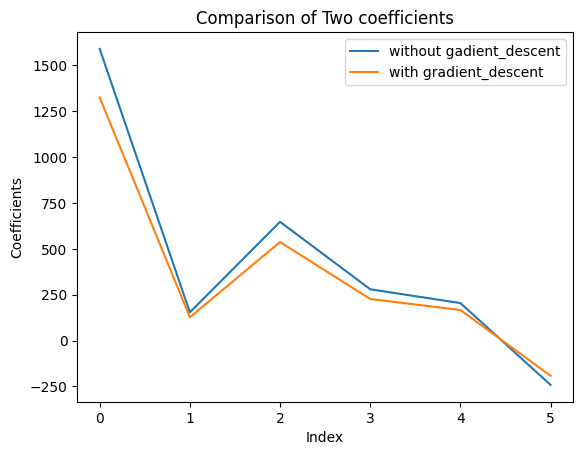

In [156]:
import matplotlib.pyplot as plt

# Plotting the graph
plt.plot(w_cap_vec, label='without gadient_descent')
plt.plot(average_m, label='with gradient_descent')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Coefficients')
plt.title('Comparison of Two coefficients')
plt.legend()

# Display the plot
plt.show()


* according to the observation from the above graph the both the coeeficients converge to a single solution.